# Matching and finding the most similar items

*Matching* is one of the basic machine learning tasks found in information retrieval, computer vision, recommender systems, etc.

**Project tasks:**

🔸 Develop an algorithm that for all items from `validation.csv` will suggest several options of the most similar products from `base`;

🔸 Evaluate the performance using Accuracy@5 metric.

--------

# Мэтчинг и поиск наиболее похожих товаров

Сопоставление или *мэтчинг* - одна из базовых задач машинного обучения, которая встречается в информационном поиске, компьютерном зрении, рекомендательных системах и др.

**Задачи проекта:**

🔸 Разработать алгоритм, который для всех товаров из `validation.csv` предложит несколько вариантов наиболее похожих товаров из `base`;

🔸 Оценить качество алгоритма по метрике Аccuracy@5.

## Neccessary imports

In [2]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
from annoy import AnnoyIndex
import gc
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
import zipfile
import requests
from urllib.parse import urlencode

## Load data from yandex.drive

In [4]:
# hidden links to data, but you can select your own data
base_url = ''
public_key = ''

final_url = base_url + urlencode(dict(public_key=public_key))
response = requests.get(final_url)
download_url = response.json()['href']

download_response = requests.get(download_url)

with open('data.zip', 'wb') as f:   
    f.write(download_response.content)

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [2]:
dict_base = {}
for i in range(72):
    dict_base[str(i)] = 'float32'
dict_base
dict_train = dict_base.copy()
dict_train['Target'] = 'str'

## Base dataset

In [3]:
df_base = pd.read_csv("base.csv", index_col=0, dtype=dict_base)

df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083893,11.152912,-64.426758,-118.880890,216.482437,-104.698059,-469.070587,44.348083,120.915344,181.449707,...,-42.808693,38.800827,-151.762177,-74.389091,63.666340,-4.703861,92.933609,115.269188,-112.756638,-60.830353
1-base,-34.562202,13.332763,-69.787613,-166.533478,57.680607,-86.098373,-85.076668,-35.637436,119.718636,195.234192,...,-117.767525,41.099998,-157.829407,-94.446808,68.202110,24.346846,179.937927,116.834000,-84.888939,-59.524609
2-base,-54.233746,6.379371,-29.210136,-133.413834,150.895828,-99.435326,52.554794,62.381706,128.951447,164.381470,...,-76.397797,46.011803,-207.144424,127.325569,65.566177,66.325684,81.073486,116.594154,-1074.464844,-32.527206
3-base,-87.520126,4.037884,-87.803032,-185.067627,76.369537,-58.985165,-383.182831,-33.611237,122.031914,136.233582,...,-70.647942,-6.358921,-147.201050,-37.692749,66.202888,-20.566910,137.206940,117.474098,-1074.464844,-72.915489
4-base,-72.743851,6.522048,43.671265,-140.608032,5.820023,-112.074081,-397.711273,45.182499,122.167183,112.119064,...,-57.199104,56.642403,-159.351837,85.944725,66.766319,-2.505783,65.315285,135.051590,-1074.464844,0.319401


In [4]:
df_base.shape

(2918139, 72)

In [5]:
df_base[['0','1','2']].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2918139 entries, 0-base to 4744766-base
Data columns (total 3 columns):
 #   Column  Dtype  
---  ------  -----  
 0   0       float32
 1   1       float32
 2   2       float32
dtypes: float32(3)
memory usage: 55.7+ MB


## Train dataset

In [6]:
df_train = pd.read_csv("train.csv", index_col=0, dtype=dict_train)

df_train.shape

(100000, 73)

In [7]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.936676,187.517487,-87.144928,-347.360596,38.307602,109.085564,30.413513,...,70.107361,-155.802567,-101.965942,65.903793,34.457500,62.642094,134.763596,-415.750244,-25.958572,675816-base
1-query,-87.776367,6.806268,-32.054546,-177.260391,120.803329,-83.810593,-94.572746,-78.433090,124.915901,140.331070,...,4.669178,-151.697708,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092163,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118591,-180.401978,190.128433,-50.837620,26.943937,-30.447489,125.771164,211.607819,...,78.039764,-169.146194,82.144188,66.008217,18.400496,212.409729,121.931473,-1074.464844,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.011360,94.652840,-109.255409,-775.150146,79.186523,124.003098,242.650650,...,44.515266,-145.416748,93.990982,64.131348,106.061920,83.178757,118.277725,-1074.464844,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.052536,57.127068,-16.239529,-321.317963,45.984676,125.941284,103.392670,...,45.028912,-196.092072,-117.626335,66.926224,42.456169,77.621765,92.479927,-1074.464844,-21.149351,717819-base


In [8]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

## EDA

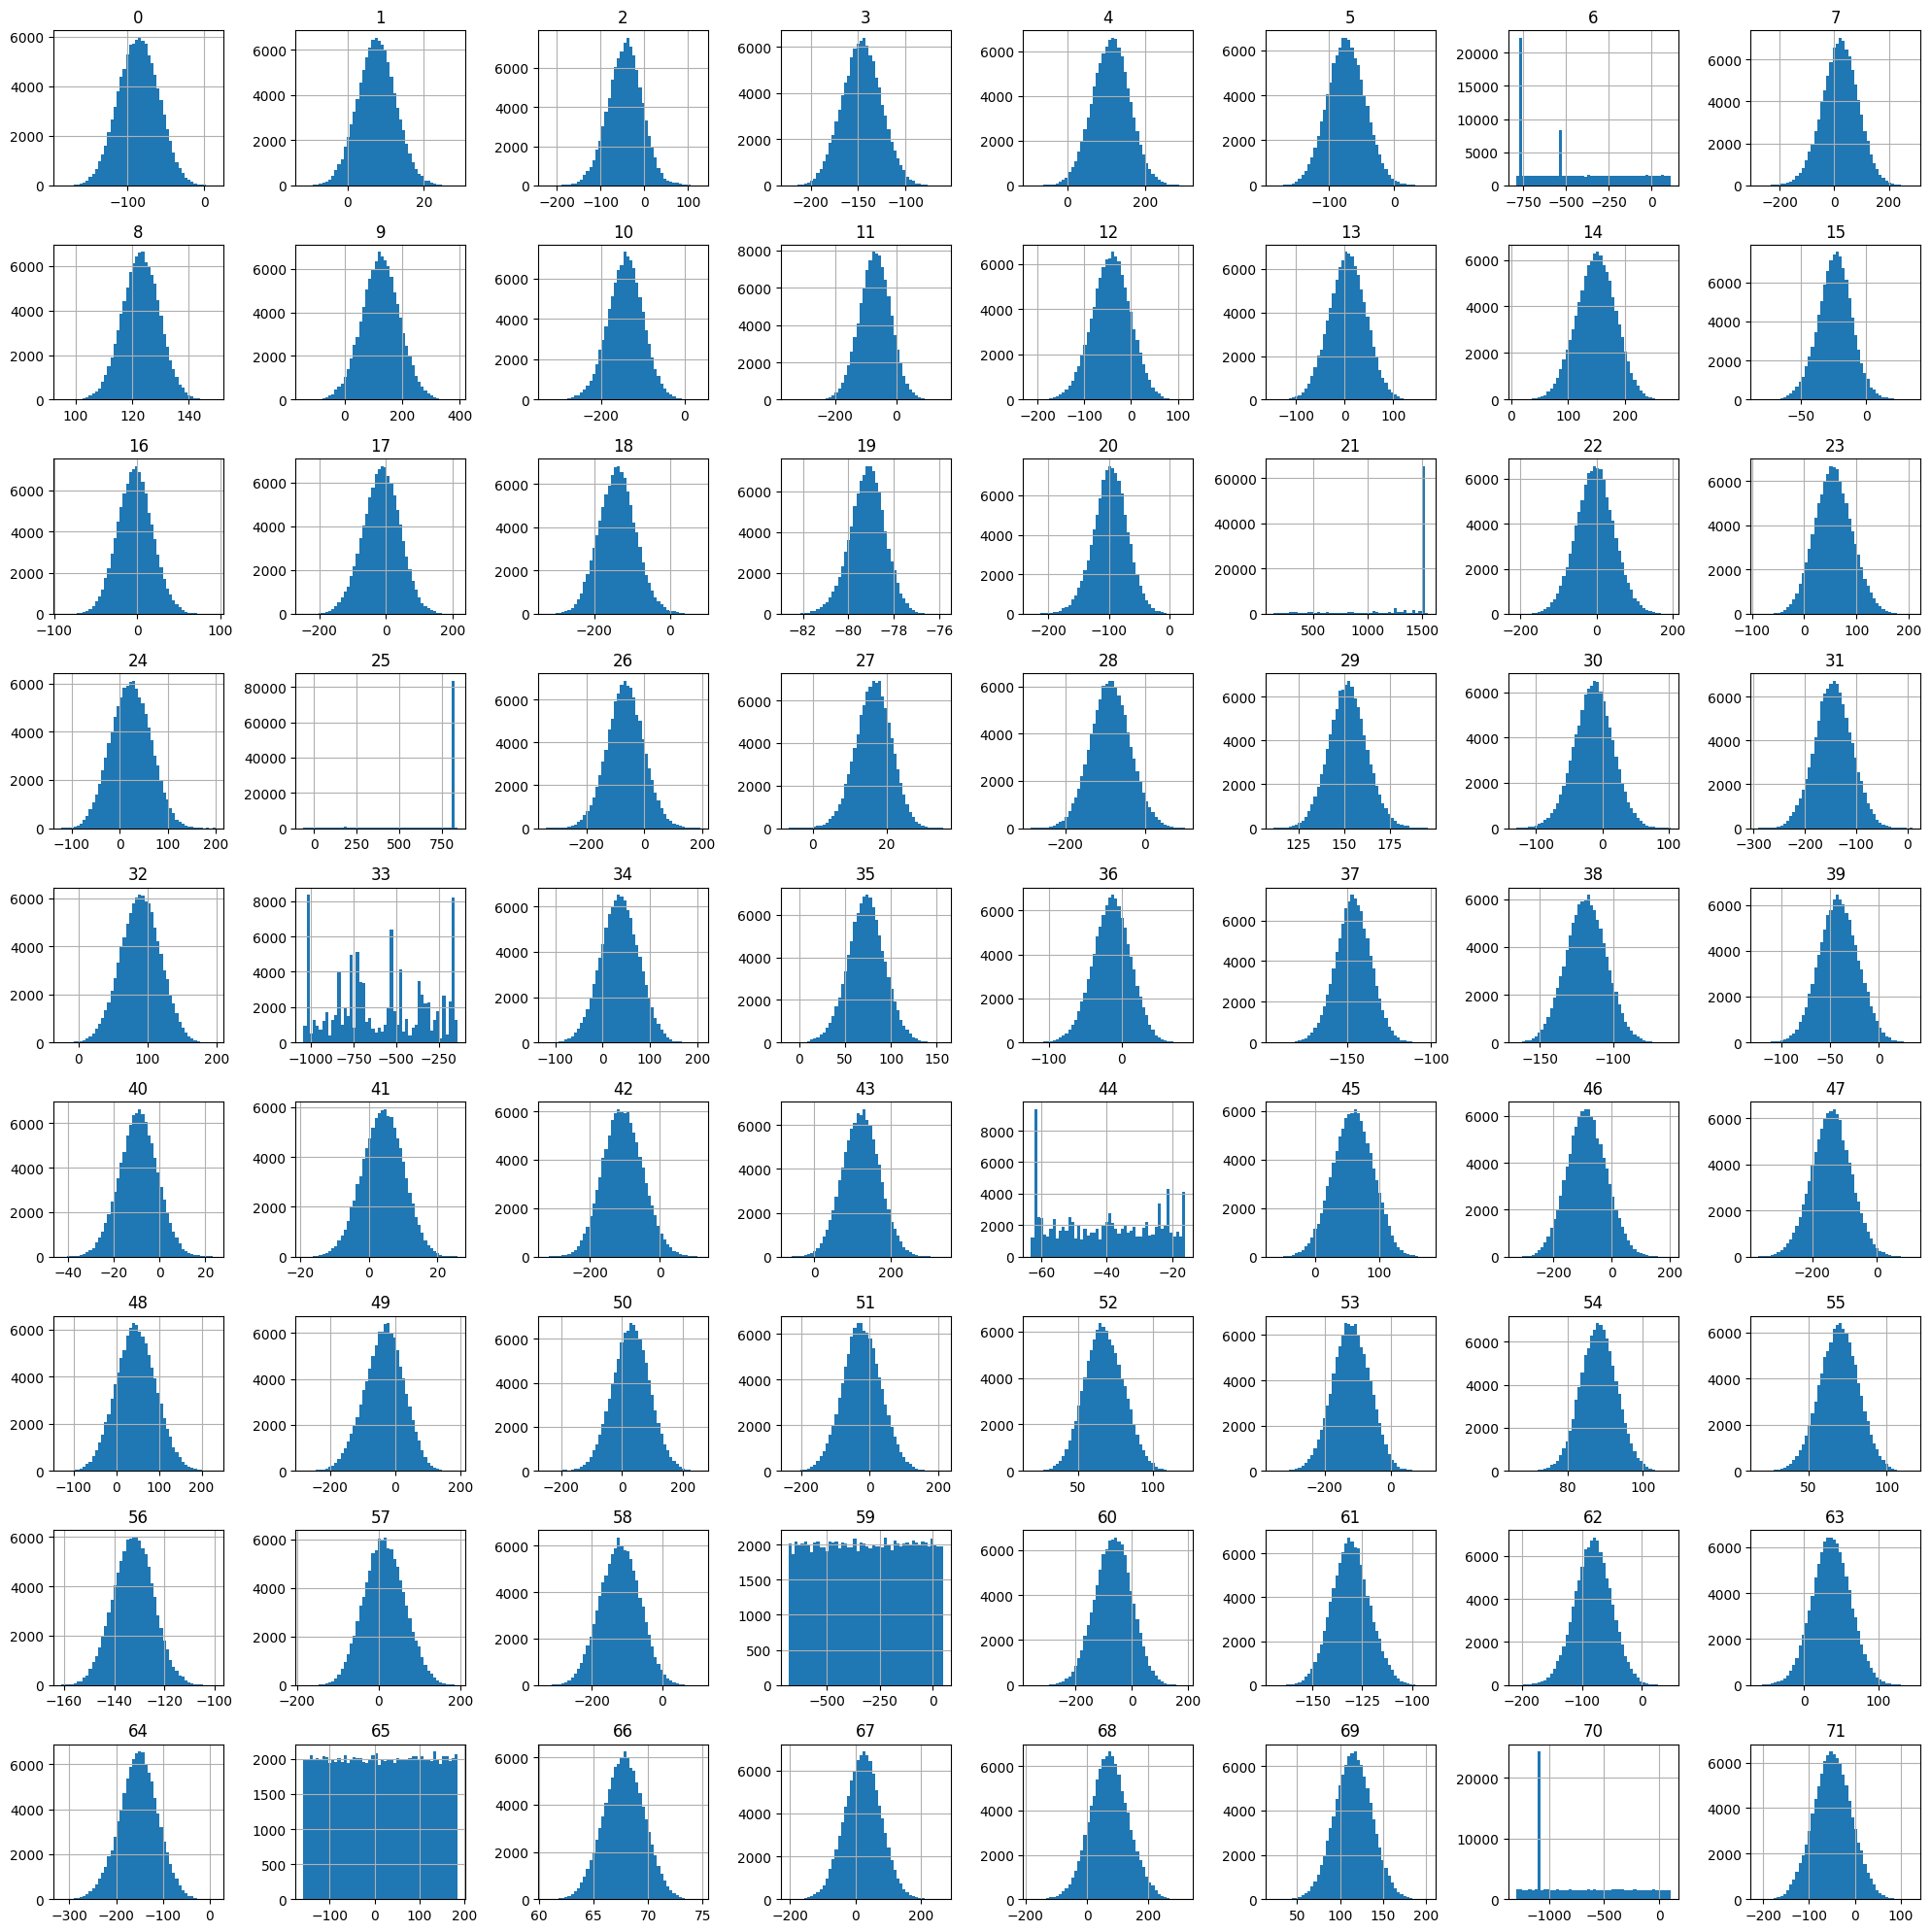

In [11]:
df_train.hist(figsize=(20, 20), bins=50)
plt.tight_layout()
plt.show()

In [12]:
# remove columns with redundant data with almost constant values
cols_to_remove = ['21', '25', '33']
df_base.drop(cols_to_remove, axis=1, inplace=True)
df_train.drop(cols_to_remove, axis=1, inplace=True)

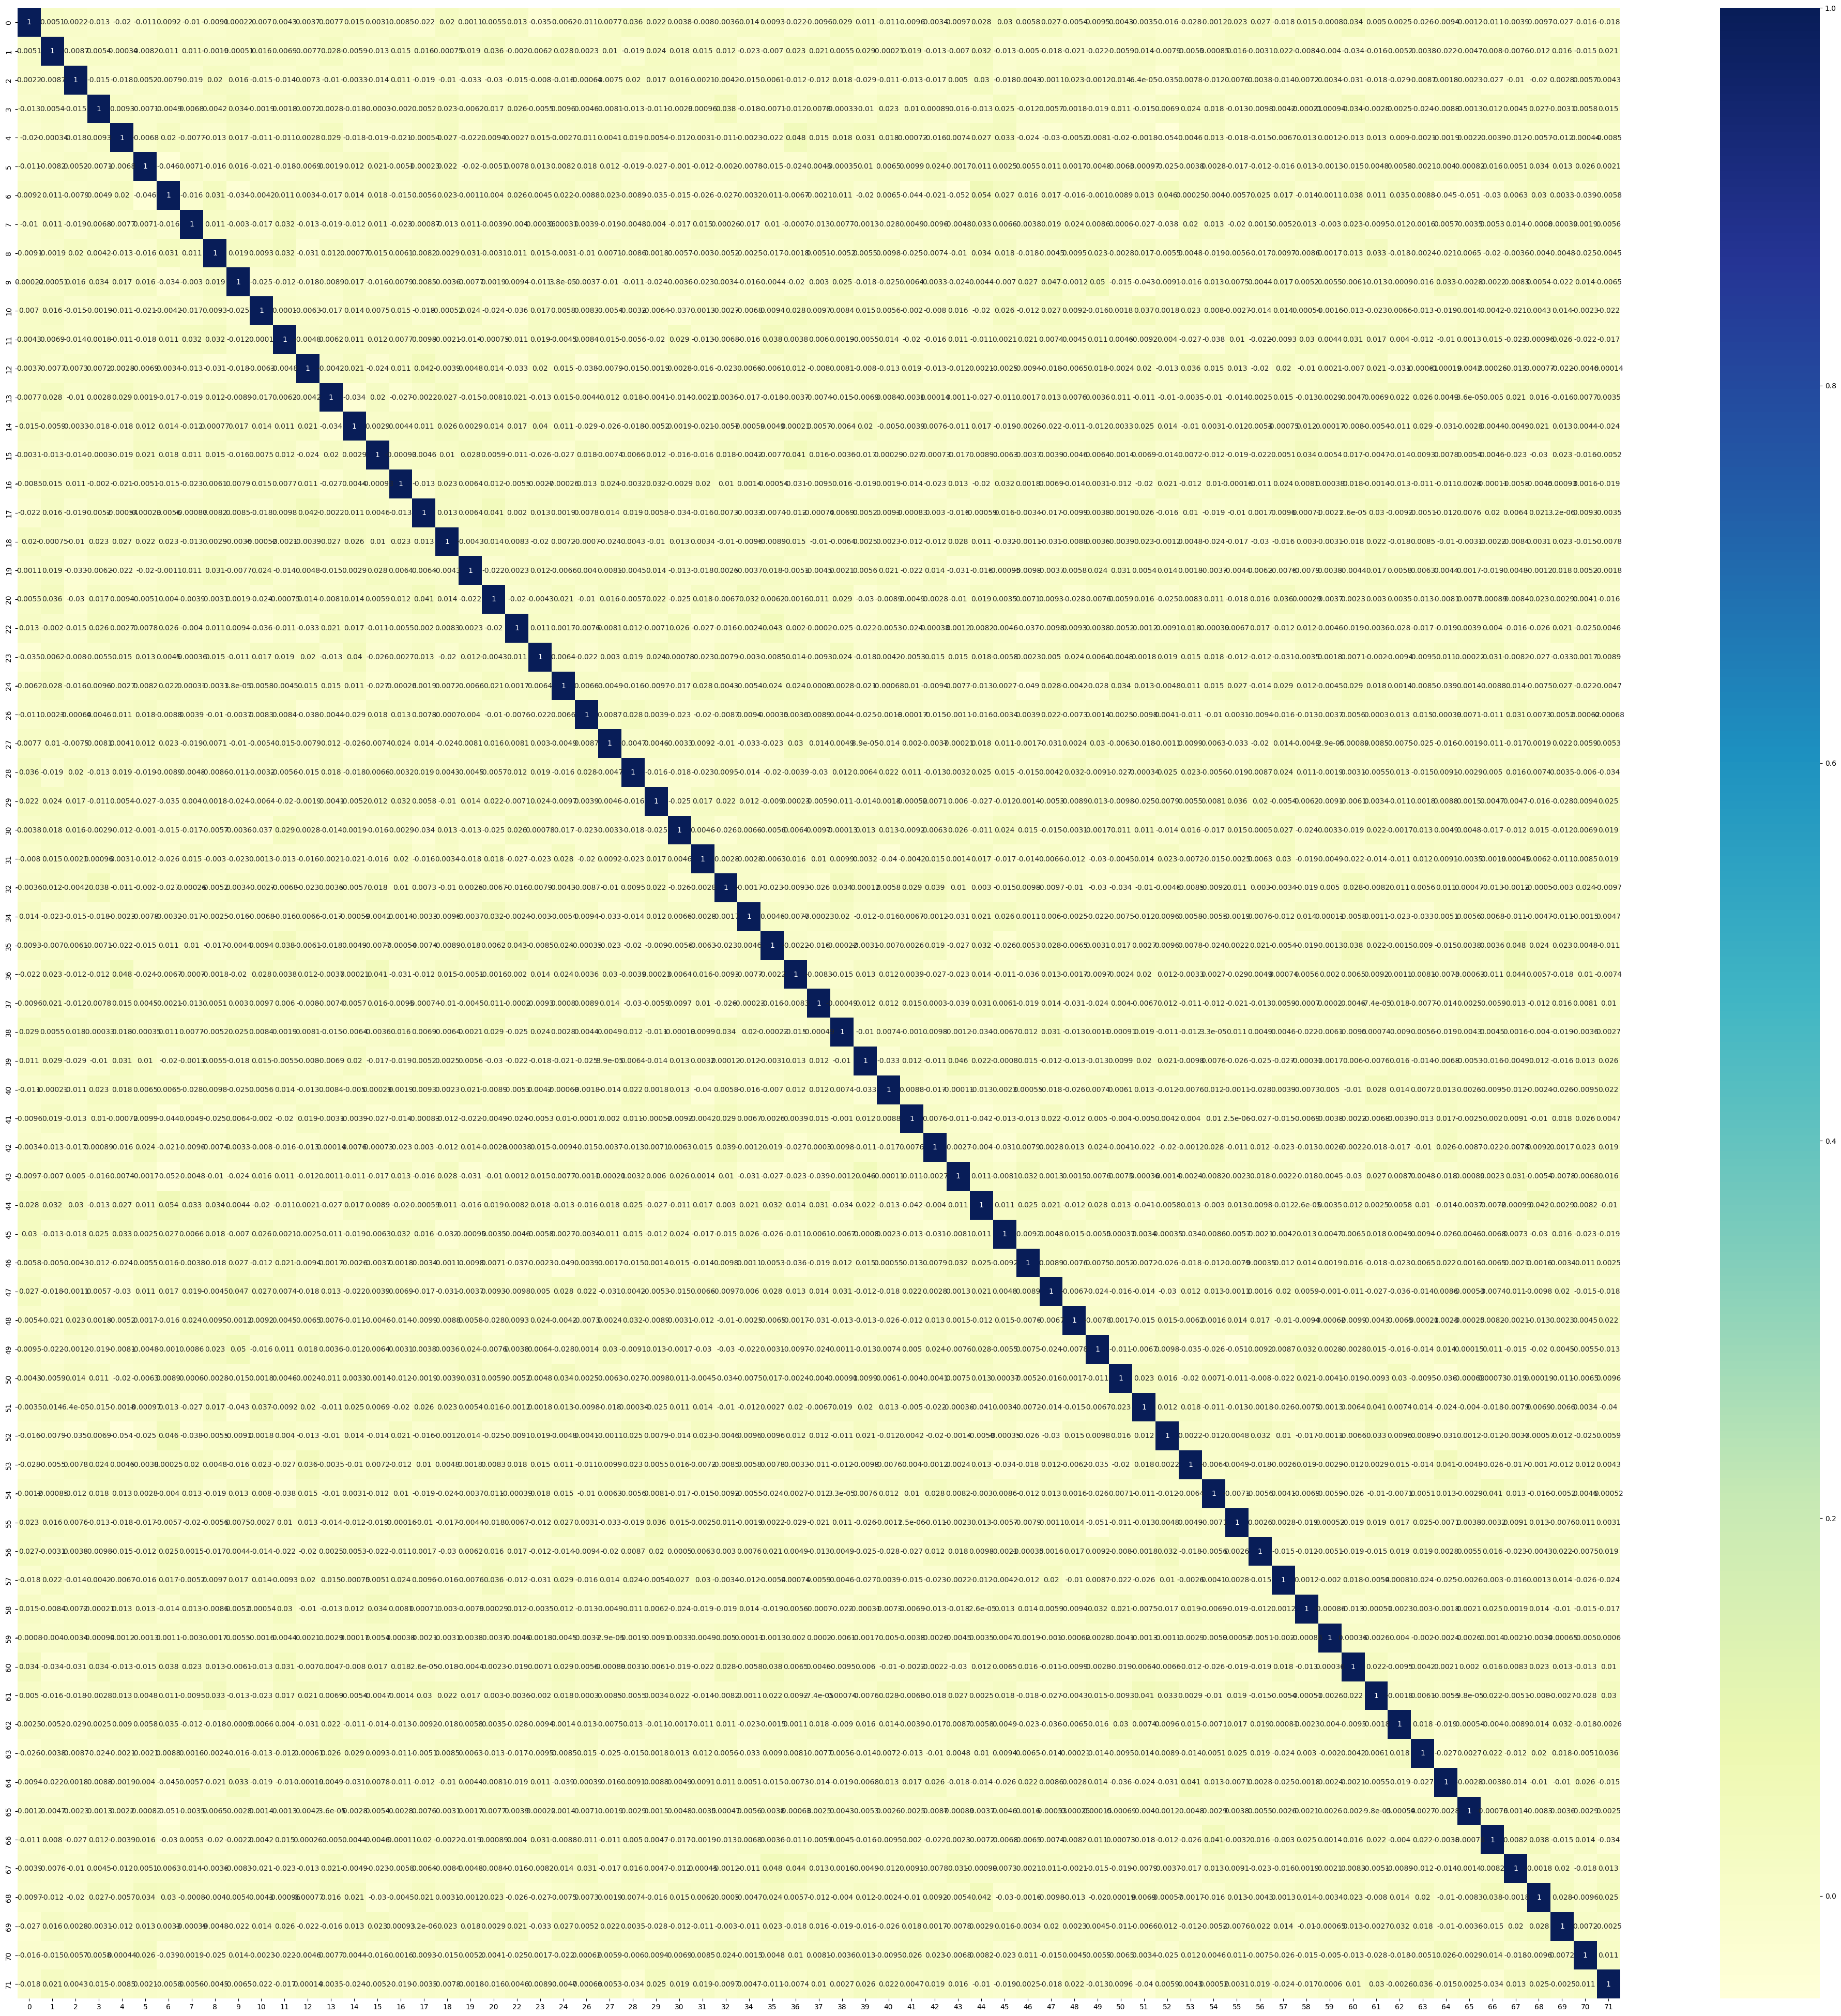

In [13]:
# print the correlation matrix
plt.figure(figsize=(50, 50))
correlation_matrix = sns.heatmap(df_train.corr(), cmap="YlGnBu", annot=True)
plt.show()

По результатам EDA, было выявлено следующее:
- Распределение признаков под номерами `21`, `25` и `33` имеет странный характер: они принимают константые значения практически для всех точек данных. Было решено убрать данные столбцы, поскольку они могут быть избыточными и ухудшить показатели точности. Также, некоторые столбцы, например под номером `44`, имеют распределения далеко от нормального или равномерного. Однако, я решила оставить данные столбцы, поскольку их удаление не повлияло на метрику качества (было выявлено эмперически).

- В данных не содержатся сильно коррелирующие признаки. Так, коэффициент корреляций между признаками составляет меньше $0.2$.

## Standardization

Для масштабирования данных, я использовала *StandardScaler*, однако, я также пробовала такие скейлеры как *RobustScaler*, *MinMaxScaler* - с их использованием метрика accuracy была ниже. 

In [14]:
# perform standard scaling
scaler = StandardScaler()
df_base_scaled = scaler.fit_transform(df_base)
df_train_scaled = scaler.transform(df_train)

## Create index

Для реализации поиска, был использован [Annoy](https://github.com/spotify/annoy) (Approximate Nearest Neighbors Oh Yeah), так как он довольно быстрый по сравнению с другими библиотеками (faiss, etc.), что подходит данной задаче с большим набором данных, и он предоставляет достаточно хорошие результаты.

In [15]:
base = np.array(df_base_scaled)

In [18]:
f = base.shape[1] # dimension of each item

In [49]:
# build index
index = AnnoyIndex(f, 'manhattan')
index.on_disk_build('test500.ann')

for i, item in enumerate(tqdm(base, total=base.shape[0])):
    index.add_item(i, item)

index.build(n_trees=500, n_jobs=-1)

base = None
gc.collect()

100%|██████████| 2918139/2918139 [00:11<00:00, 254307.95it/s]


530

In [16]:
def get_vector_index():
    # returns index object
    index = AnnoyIndex(f, 'manhattan')
    index.load('test500.ann')
    return index

def get_kNN_items(item, k, index):
    # returns k nearest neighbor indices of an item
    neigbor_ids = index.get_nns_by_vector(item, 
                                          k, 
                                          search_k=-1, 
                                          include_distances=False)
    
    return neigbor_ids

In [51]:
index = get_vector_index()

In [52]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}

In [53]:
# check the accuracy on the first 10000 items
acc = 0
for target, item in tqdm(zip(targets[:10000].values, df_train_scaled[:10000]), 
                         total=10000):
    
    neigbor_ids = get_kNN_items(item, 5, index)
    acc += int(target in [base_index[idx] for idx in neigbor_ids])
    
print(acc / 10000)

100%|██████████| 10000/10000 [03:57<00:00, 42.11it/s]

0.7163


In [54]:
# compute the accuracy on the whole train dataset
acc = 0
for target, item in tqdm(zip(targets.values, df_train_scaled), 
                         total=df_train_scaled.shape[0]):
    
    neigbor_ids = get_kNN_items(item, 5, index)
    acc += int(target in [base_index[idx] for idx in neigbor_ids])
    
    
print(f'Accuracy: {acc / df_train_scaled.shape[0]}')

100%|██████████| 100000/100000 [41:16<00:00, 40.38it/s] 

Accuracy: 0.71088


Таким образом, поиск ближайших 5 товаров по `base` для товаров из датасета `train.csv` при использовании `Annoy Index` показал метрику accuracy@5, равную $71, 1$%.

## Validation dataset

In [9]:
df_val = pd.read_csv("validation.csv", index_col=0, dtype=dict_train)

df_val.shape

(100000, 72)

In [21]:
# remove columns with redundant data 
df_val.drop(cols_to_remove, axis=1, inplace=True)

In [22]:
# perform standard scaling
df_val_scaled = scaler.transform(df_val)

In [23]:
# get index
index = get_vector_index()

In [26]:
val_answers = pd.read_csv("validation_answer.csv", index_col=0, dtype=dict_train)

In [28]:
val_answers.head()

,Expected
Id,
100000-query,2676668-base
100001-query,91606-base
100002-query,472256-base
100003-query,3168654-base
100004-query,75484-base


In [54]:
# compute the accuracy on the validation dataset
# find 5 closest for validation dataset and store them in a dictionary
acc_val = 0
val_5_dict = {}

for expected, id, val_item in tqdm(zip(val_answers['Expected'].values, 
                                       val_answers['Expected'].index, 
                                       df_val_scaled), 
                                   total=df_val_scaled.shape[0]):
    
    neigbor_ids = get_kNN_items(val_item, 5, index)
    val_5_dict[id] = [base_index[idx] for idx in neigbor_ids]
    acc_val += int(expected in [base_index[idx] for idx in neigbor_ids])
    
print(f'Accuracy: {acc_val / df_val_scaled.shape[0]}')

100%|██████████| 100000/100000 [1:02:10<00:00, 26.81it/s]

Accuracy: 0.7093


In [55]:
# store the results with 5 most similar items in a dataframe
val_5_targets = pd.DataFrame()
val_5_targets['id'] = val_5_dict.keys()
for i in range(5):
    val_5_targets[f'target_{i}'] = [val_5_dict[key][i] for key in val_5_dict.keys()]

val_5_targets['expected'] = val_answers['Expected'].values

In [56]:
val_5_targets.head()

,id,target_0,target_1,target_2,target_3,target_4,expected
0,100000-query,2760762-base,3209652-base,3839597-base,3181043-base,368296-base,2676668-base
1,100001-query,163485-base,2666508-base,3890545-base,11853-base,1000521-base,91606-base
2,100002-query,472256-base,153272-base,496010-base,25113-base,298322-base,472256-base
3,100003-query,3168654-base,2345993-base,1831175-base,2177262-base,4473809-base,3168654-base
4,100004-query,75484-base,1217188-base,2366033-base,902380-base,1656711-base,75484-base


In [57]:
# save the results
val_5_targets.to_csv('val_5_targets.csv', index=False)

## Итог:

Таким образом, поиск ближайших 5 товаров по `base` для товаров из датасета `validation.csv` при использовании `Annoy Index` показал метрику accuracy@5, равную $70, 9$%, сравнимую с метрикой на датасете из `train.csv`. 

Также, был составлен датасет `val_5_targets.csv`, который содержит в себе следующие признаки: id для validation query (`id`), полученные 5 ближайших соседей для данного query (`target_0`-`target_4`), а также ожидаемый один ближайший результат (`expected`), полученный из `validation_answers.csv`. Его можно найти в директории `results/` в репозитории.